# Fraud Detection in Financial Transactions using XGBoost

This notebook demonstrates how to use XGBoost to detect fraud in financial transactions. The dataset used in this notebook is the [PaySim dataset](https://www.kaggle.com/ealaxi/paysim1) from Kaggle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
fraud_data = pd.read_csv('PS_log.csv')
print(fraud_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [3]:
# splitting the data into training and testing data
X = fraud_data.drop('isFraud', axis=1)
y = fraud_data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [4]:
X_train.select_dtypes(include = ['int64','float64']).head() # selecting only numerical columns

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
950383,44,28970.24,5043.00,0.0,0.00,28970.24,0
4726448,332,113276.32,766.00,0.0,1395944.95,1509221.27,0
812365,40,7111.48,0.00,0.0,0.00,0.00,0
2674942,210,380425.14,229653.00,0.0,124339.15,504764.29,0
5703950,398,27822.19,451325.69,423503.5,0.00,0.00,0


In [5]:
# describe the data
X_train.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06
mean,2.433756e+02,1.795409e+05,8.339621e+05,8.551061e+05,1.099082e+06,1.223002e+06,1.833626e-06
std,1.423157e+02,5.962817e+05,2.886890e+06,2.922675e+06,3.400762e+06,3.672956e+06,1.354113e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338955e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.480065e+04,1.419500e+04,0.000000e+00,1.327189e+05,2.146385e+05,0.000000e+00
75%,3.350000e+02,2.086503e+05,1.073590e+05,1.442616e+05,9.419022e+05,1.110725e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.039905e+07,4.368662e+07,3.560159e+08,3.561793e+08,1.000000e+00


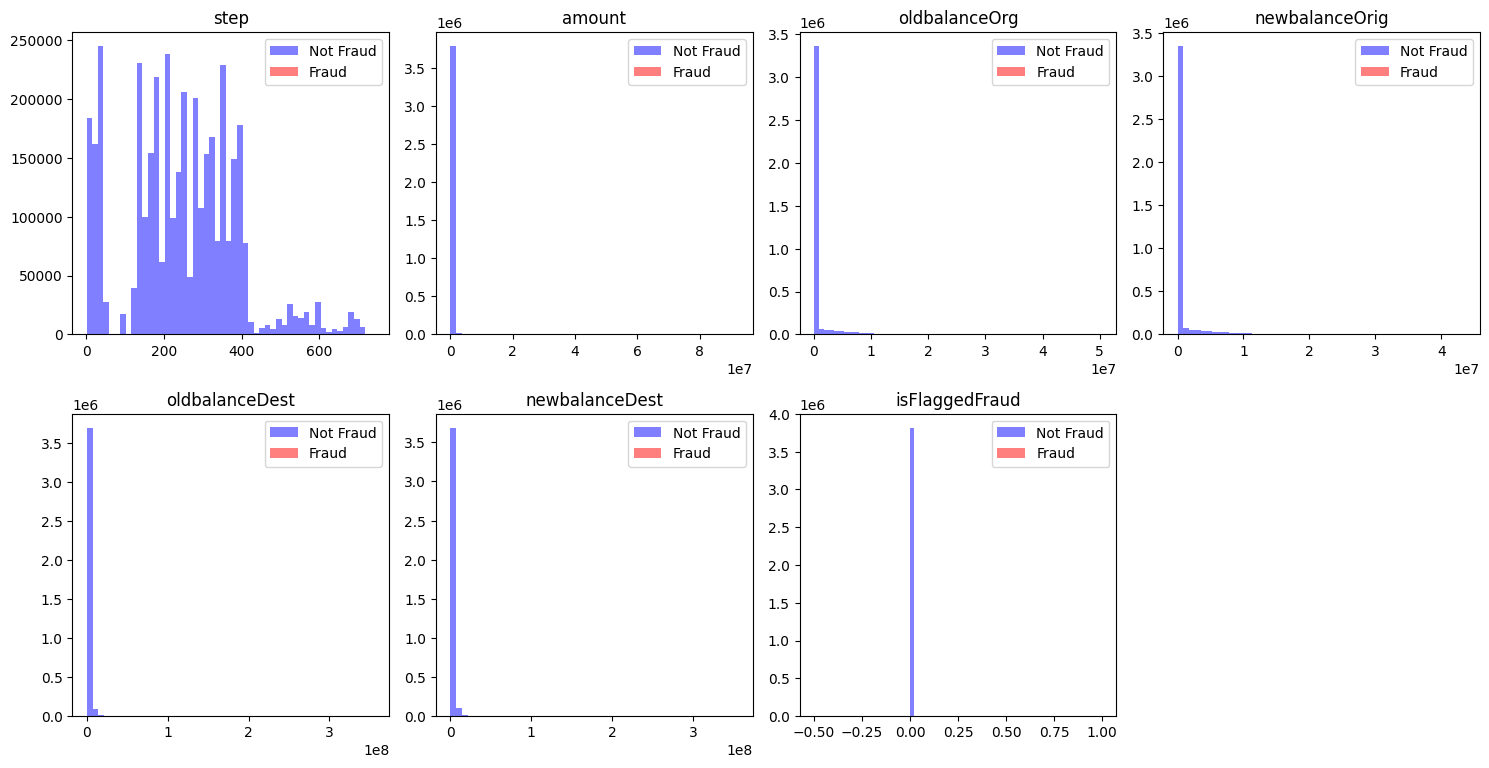

In [6]:
# Graph all numerical columns to see the distribution in one figure, fraud in red, non-fraud in blue
plt.figure(figsize=(15, 15))
for i, col in enumerate(X_train.select_dtypes(include = ['int64','float64']).columns):
    plt.subplot(4, 4, i + 1)
    plt.hist(X_train[y_train == 0][col], bins=50, color='b', alpha=0.5, label='Not Fraud')
    plt.hist(X_train[y_train == 1][col], bins=50, color='r', alpha=0.5, label='Fraud')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

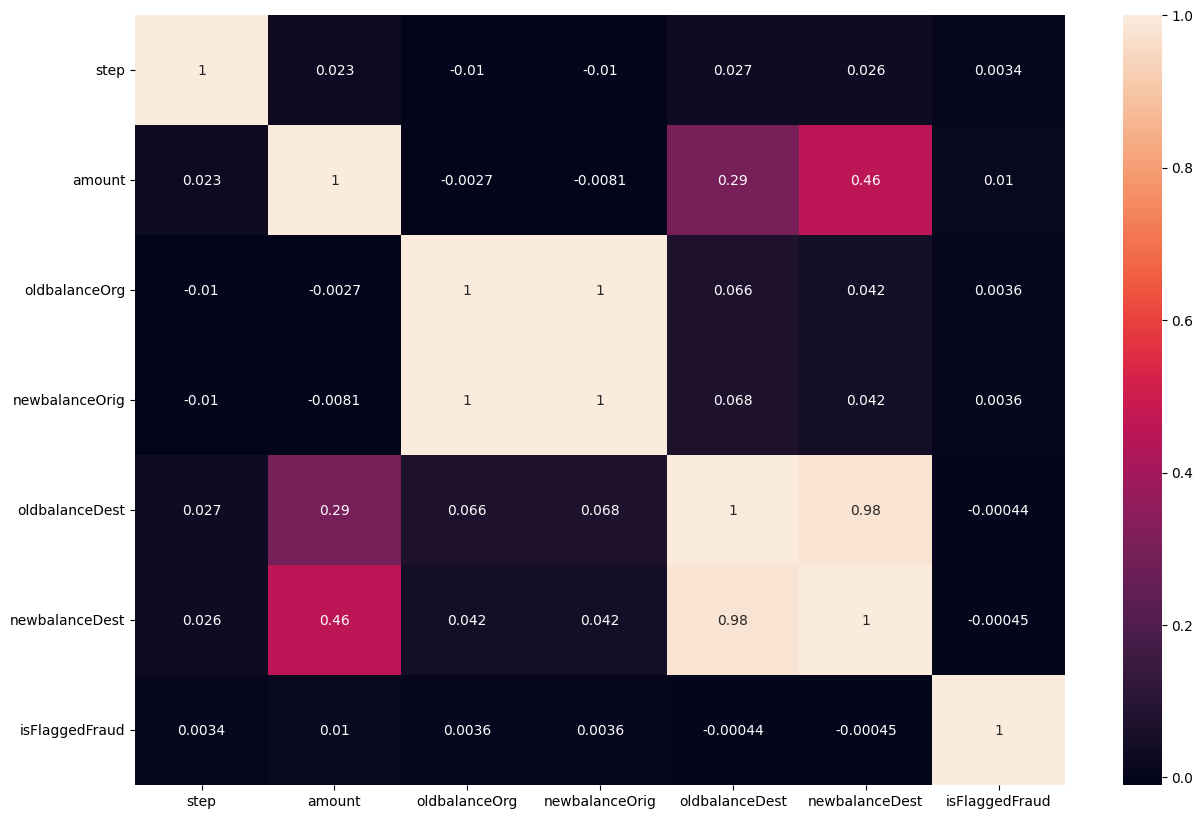

In [7]:
## Correlation matrix heatmap with feature names for numerical columns
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.heatmap(X_train.select_dtypes(include = ['int64','float64']).corr(), annot=True)
plt.show()

In [8]:
# Normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include = ['int64','float64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include = ['int64','float64']))

# describe the data after scaling
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6
count,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06,3.817572e+06
mean,3.573411e-17,3.047098e-17,1.912985e-16,-9.973794e-17,1.493010e-16,1.565347e-16,-4.634712e-19
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.703084e+00,-3.011009e-01,-2.888791e-01,-2.925766e-01,-3.231870e-01,-3.329750e-01,-1.354116e-03
25%,-6.139563e-01,-2.786458e-01,-2.888791e-01,-2.925766e-01,-3.231870e-01,-3.329750e-01,-1.354116e-03
50%,-3.074579e-02,-1.756557e-01,-2.839620e-01,-2.925766e-01,-2.841608e-01,-2.745375e-01,-1.354116e-03
75%,6.438109e-01,4.881814e-02,-2.516906e-01,-2.432171e-01,-4.621900e-02,-3.056870e-02,-1.354116e-03
max,3.510677e+00,1.547356e+02,1.716903e+01,1.465490e+01,1.043639e+02,9.664052e+01,7.384893e+02


The fraudulant transactions are a small fraction of the total transactions. This makes the dataset imbalanced. Decision trees and ensemble methods like XGBoost are known to perform well on imbalanced datasets.

In [9]:
# Train the model using XGBoost
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Figure size 1000x500 with 0 Axes>

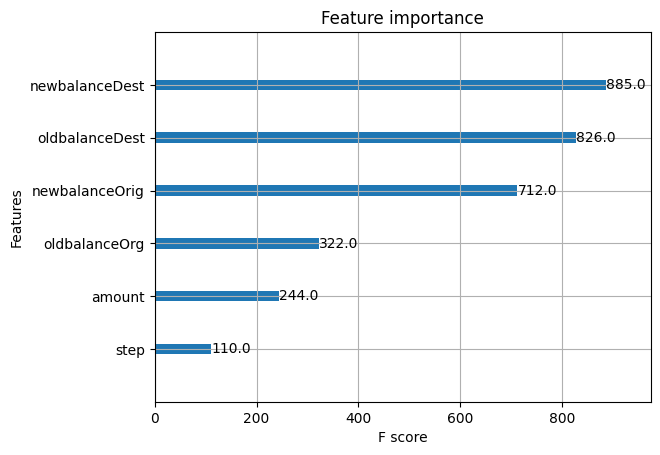

In [10]:
# Graph importance of features
plt.figure(figsize=(10, 5))
xgb.plot_importance(model, importance_type='weight')
feature_names = X_train.select_dtypes(include = ['int64','float64']).columns
feature_names = feature_names.drop('isFlaggedFraud')
plt.yticks(range(len(feature_names)), feature_names)
plt.show()

In [11]:
# Predict the test data
y_pred = model.predict(X_test_scaled)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9996573738491377
